In [ ]:
!pip install natasha
!pip install -U bertopic
!pip install bertopic[visualization] sentence-transformers

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 34.6 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=48ccd43fd19bbc7e8322428358df4bd37265ce4c8ca980440c319b29ebb4dc86
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=142b44cd7b886e876974882f5fb1dd1395136cf748bc575c9f7260c6b834849b
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built docopt intervaltree
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast

import torch
import torch.nn.functional as F
from torch import nn
# from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorWithPadding

import pandas as pd
import numpy as np
from tqdm import tqdm
import json

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsNERTagger,
    Doc
)

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from scipy.stats import shapiro, levene, ttest_ind
from datetime import datetime, timedelta

In [ ]:
df = pd.read_csv("comments.csv")
df['publishedAt'] = pd.to_datetime(df['publishedAt'])
df.head(3)

,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelIdValue,textDisplay,textOriginal,parentId,canRate,viewerRating,likeCount,publishedAt,updatedAt,video_id
0,@АннаСтарченко-ж1ъ,https://yt3.ggpht.com/ytc/AIdro_m40uRQD0SxNcc-...,http://www.youtube.com/@%D0%90%D0%BD%D0%BD%D0%...,UCMg02x4OLw7RahqREHJuwWg,Теперь мне жалко макрофагов:с,Теперь мне жалко макрофагов:с,NaN,True,none,0,2024-10-29 11:40:02+00:00,2024-10-29T11:40:02Z,o4nxYwym_4E
1,@ЕгорАгапитов-г3ц,https://yt3.ggpht.com/ytc/AIdro_lhWMxx2fFqOSRB...,http://www.youtube.com/@%D0%95%D0%B3%D0%BE%D1%...,UCOyKKleAvD4xSm_Mybfi_dA,Похуй у меня нет этого дерьмо,Похуй у меня нет этого дерьмо,NaN,True,none,0,2024-10-29 08:58:04+00:00,2024-10-29T08:58:04Z,o4nxYwym_4E
2,@pablusmercy1627,https://yt3.ggpht.com/ytc/AIdro_m_G9_jZ09w8Gn0...,http://www.youtube.com/@pablusmercy1627,UC2LRy5SPEyUfKBtDzoWU_KA,Жалко этих добряков,Жалко этих добряков,NaN,True,none,0,2024-10-29 06:12:08+00:00,2024-10-29T06:12:08Z,o4nxYwym_4E


# Sentiment analysis

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment-rusentiment')
model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment-rusentiment', return_dict=True)

tokenizer_config.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/952 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

In [ ]:
def process_sentiment_analysis(texts, model, batch_size=16, device='cpu') -> np.array:
    """
    Perform sentiment analysis on a list of text inputs using a given model.

    :param texts: List of strings to analyze.
    :param model: Pretrained model for sentiment analysis (e.g., Hugging Face transformer).
    :param batch_size: Number of texts to process in a single batch. Default is 16.
    :param device: Device to use for model inference ('cpu' or 'cuda'). Default is 'cpu'.
    :return: Numpy array of predicted sentiment classes for each text (e.g., 0: neutral, 1: positive, 2: negative).
    """
    sentiments = []
    model = model.to(device)

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch = texts[i:i+batch_size]
            try:
                inputs = tokenizer(batch, max_length=512, padding=True, truncation=True, return_tensors='pt').to(device)
            except:
                print(batch)
                break
            outputs = model(**inputs)
            predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
            predicted = torch.argmax(predicted, dim=1).cpu().numpy()
            sentiments.append(predicted)

    sentiments = np.concatenate(sentiments)

    return sentiments


def sentiment_analytics(sentiments, timestamp=''):
    """
    Calculate sentiment statistics for a given array of sentiment predictions.

    :param sentiments: Numpy array of sentiment predictions (0: neutral, 1: positive, 2: negative).
    :param timestamp: Optional timestamp for the analysis. Default is an empty string.
    :return: Dictionary containing sentiment counts, percentages, a proportion metric, and the timestamp.
    """
    answer = {}

    mask_positive = sentiments == 1
    mask_negative = sentiments == 2
    mask_neutral = sentiments == 0

    cnt_positive = np.sum(mask_positive)
    cnt_negative = np.sum(mask_negative)
    cnt_neutral = np.sum(mask_neutral)

    cnt_comments = cnt_positive + cnt_negative + cnt_neutral

    answer['positive'] = cnt_positive
    answer['negative'] = cnt_negative
    answer['neutral'] = cnt_neutral
    answer['positive_perc'] = (100 * cnt_positive / cnt_comments)
    answer['negative_perc'] = (100 * cnt_negative / cnt_comments)
    answer['neutral_perc'] = (100 * cnt_neutral / cnt_comments)
    answer['proportion_metric'] = np.mean(sentiments)
    answer['timestamp'] = timestamp

    return answer


def plot_dynamics(values, title="Динамика значений",
                  xlabel="Дата и время", ylabel="Значение"):
    """
    Plot sentiment dynamics over time.

    :param values: List of dictionaries containing timestamps and sentiment percentages
                   (keys: 'timestamp', 'positive_perc', 'negative_perc', 'neutral_perc').
    :param title: Title of the plot. Default is "Динамика значений".
    :param xlabel: Label for the X-axis. Default is "Дата и время".
    :param ylabel: Label for the Y-axis. Default is "Значение".
    :return: None. Displays the plot.
    """

    dates = [stat['timestamp'] for stat in values]
    values1 = [stat['positive_perc'] for stat in values]
    values2 = [stat['negative_perc'] for stat in values]
    values3 = [stat['neutral_perc'] for stat in values]
    label1 = 'Процент позитивных комментариев'
    label2 = 'Процент негативных комментариев'
    label3 = 'Процент нейтральных комментариев'

    if not values1 or not values2:
        raise ValueError("Оба списка значений не должны быть пустыми.")

    plt.figure(figsize=(10, 6))
    plt.plot(dates, values1, marker='o', linestyle='-', color='b', label=label1)
    plt.plot(dates, values2, marker='s', linestyle='--', color='r', label=label2)
    # plt.plot(dates, values3, marker='s', linestyle='-.', color='grey', alpha=0.5, label=label3)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate(rotation=60, ha='right')

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()


def normal_dist_test(sample: np.array) -> bool:
     """
    Test whether a given sample follows a normal distribution.

    :param sample: Numpy array of sample values.
    :return: True if the sample follows a normal distribution, False otherwise.
    """
    mean_sample = []
    for i in range(500):
        subsample = np.random.choice(sample, size=100)
        mean_sample.append(np.mean(subsample))

    mean_sample = np.array(mean_sample)
    result = shapiro(mean_sample).statistic

    if result > 0.05:
        return True
    return False


def var_equality_test(sample1: np.array, sample2: np.array) -> bool:
    """
    Test whether two samples have equal variance.

    :param sample1: First numpy array of sample values.
    :param sample2: Second numpy array of sample values.
    :return: True if the variances are equal, False otherwise.
    """
    result = levene(sample1, sample2).statistic

    if result > 0.05:
        return True
    return False


def are_emotions_same(s1: np.array, s2: np.array) -> bool:
    """
    Determine if two sentiment samples are statistically similar using hypothesis testing.

    :param s1: First numpy array of sentiment predictions.
    :param s2: Second numpy array of sentiment predictions.
    :return: True if the sentiment distributions are statistically similar, False otherwise.
    """
    sz = np.min([len(s1), len(s2)])
    sample1 = np.random.choice(s1, size=sz)
    sample2 = np.random.choice(s2, size=sz)

    if not normal_dist_test(sample1) or not normal_dist_test(sample2):
        print('not normal distribution')
        return False

    result = ttest_ind(sample1, sample2, equal_var=var_equality_test(sample1, sample2)).pvalue

    print(f't-test pvalue: {result}')

    if result > 0.05:
        return True
    return False


def get_emotional_dynamics_in_video(video_id, df, start, end, model, device, detailing='h'):
    """
    Analyze the emotional dynamics of comments for a specific video within a time range.

    :param video_id: ID of the video to analyze.
    :param df: DataFrame containing comments data with 'video_id' and 'publishedAt' columns.
    :param start: Start time (datetime object) for the analysis.
    :param end: End time (datetime object) for the analysis.
    :param model: Pretrained model for sentiment analysis.
    :param device: Device for model inference ('cpu' or 'cuda').
    :param detailing: Granularity of the analysis ('m': minute, 'h': hour, 'd': day). Default is 'h'.
    :return: List of dictionaries containing sentiment analytics for each time interval.
    """
    sample = df[df['video_id'] == video_id]
    max_iter = 100
    comments = np.array([])
    answer = []

    iter = 0

    current_time = start
    while current_time <= end:
        prev_current_time = current_time
        if detailing == 'm':
            addition = sample[(sample.publishedAt >= current_time) & (sample.publishedAt < current_time + timedelta(minutes=1))]
            current_time += timedelta(minutes=1)
        elif detailing == 'h':
            addition = sample[(sample.publishedAt >= current_time) & (sample.publishedAt < current_time + timedelta(hours=1))]
            current_time += timedelta(hours=1)
        elif detailing == 'd':
            addition = sample[(sample.publishedAt >= current_time) & (sample.publishedAt < current_time + timedelta(days=1))]
            current_time += timedelta(days=1)

        if addition.empty:
            continue

        iter += 1

        result = process_sentiment_analysis(addition['textDisplay'].fillna('').values.tolist(), model, device=device)
        if (len(comments) == 0):
            comments = np.array(result)
        else:
            comments = np.concatenate((comments, result))

        analytics = sentiment_analytics(comments, prev_current_time)
        answer.append(analytics)

        if iter >= max_iter:
            print('Limit reached')
            break

    return answer


In [ ]:
texts = df['textDisplay'].fillna('').values.tolist()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# sentiments = process_sentiment_analysis(texts, model, batch_size=16, device=device)
dyn = get_emotional_dynamics_in_video('o4nxYwym_4E', df, pd.Timestamp('2024-10-18', tz='UTC'), pd.Timestamp('2024-10-29', tz='UTC'), model, device, 'h')

100%|██████████| 1/1 [00:00<00:00, 76.75it/s]


Limit reached


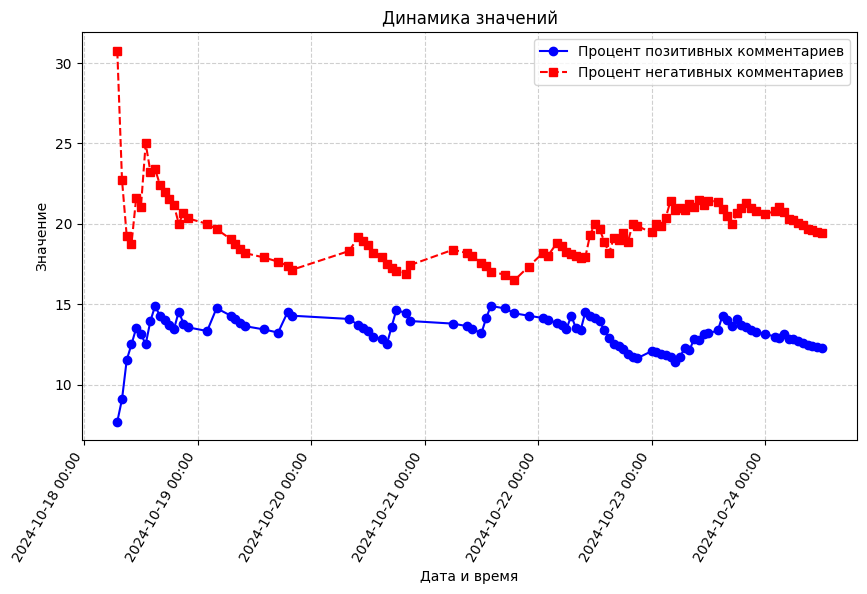

In [ ]:
plot_dynamics(dyn)

In [ ]:
test1 = np.random.choice(sentiments, size=10)
test2 = np.random.choice(sentiments, size=400)

are_emotions_same(test1, test2)

t-test pvalue: 0.048037527740947175


False

In [ ]:
response = sentiment_analytics(sentiments, df)
response

'{"positive_perc": 33.69454696090985, "negative_perc": 8.426225804021993, "neutral_perc": 57.879227235068164, "proportion_metric": 0.5055119889289513}'

# Clustering

In [ ]:
def comment_vector(tokens):
    """
    Generate a single vector representation of a comment using word embeddings.

    :param tokens: List of tokenized words from a comment.
    :return: Numpy array representing the mean vector of the tokens in the comment.
             Returns a zero vector if no tokens have embeddings in the model.
    """
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if len(vectors) == 0:
        return np.zeros(w2v_model.vector_size)
    else:
        return np.mean(vectors, axis=0)


def kmeans_clustering(df, comment_vectors, n_clusters=10, max_iter=300):
    """
    Perform KMeans clustering on comment vectors.

    :param df: DataFrame containing comments and additional metadata.
    :param comment_vectors: Numpy array of comment vector representations.
    :param n_clusters: Number of clusters to form. Default is 10.
    :param max_iter: Maximum number of iterations for the KMeans algorithm. Default is 300.
    :return: Trained KMeans object with cluster assignments.
    """
    scaler = StandardScaler()
    comment_vectors_scaled = scaler.fit_transform(comment_vectors)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, max_iter=max_iter).fit(comment_vectors_scaled)

    return kmeans


def ward_clustering(df, comment_vectors, n_clusters=10):
    """
    Perform hierarchical clustering using the Ward linkage method on comment vectors.

    :param df: DataFrame containing comments and additional metadata.
    :param comment_vectors: Numpy array of comment vector representations.
    :param n_clusters: Number of clusters to form. Default is 10.
    :return: Trained AgglomerativeClustering object with cluster assignments.
    """
    scaler = StandardScaler()
    comment_vectors_scaled = scaler.fit_transform(comment_vectors)

    ward = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(comment_vectors_scaled)

    return ward

In [ ]:
# Preparing Word2Vec model
# TODO: use pretrained word2vec model
nltk.download('punkt_tab')
df['tokens'] = df['textDisplay'].astype(str).apply(word_tokenize)
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=2, sg=1)
df['comment_vector'] = df['tokens'].apply(comment_vector)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Clustering KMeans
comment_vectors = np.vstack(df['comment_vector'].values)
kmeans = kmeans_clustering(df, comment_vectors, n_clusters=10, max_iter=300)

clusters = kmeans.labels_
df['cluster'] = clusters
df['cluster'].value_counts()

for cluster_id in df['cluster'].unique():
    print(f"\nCluster {cluster_id}:")
    print(df[df['cluster'] == cluster_id]['textDisplay'].head(5))


Cluster 3:
0                        Теперь мне жалко макрофагов:с
1                        Похуй у меня нет этого дерьмо
2                                  Жалко этих добряков
3    какую же он несёт чушь, и вот это собирает мил...
4                       То есть по сути потеря энергии
Name: textDisplay, dtype: object

Cluster 0:
20    микрофаги пожирают и переваривают. А выкакиваю...
23              Получается мы ухудшаем имунную систему?
35                            Сбой системы "свой-чужой"
36         Выходит что тату это хроническое воспаление?
43                                                    😮
Name: textDisplay, dtype: object

Cluster 2:
24                                 Фу блин... Фу блин!!
28                                         макрофаги <3
49                             Макрофаги те ещё няши! 😊
74    Лица татуированных женщин представили?) когда ...
81                                             Охренеть
Name: textDisplay, dtype: object

Cluster 6:
45                

In [ ]:
# Clustering Ward
comment_vectors = np.vstack(df['comment_vector'].values)
ward = ward_clustering(df, comment_vectors, n_clusters=10)

clusters = ward.labels_
df['cluster'] = clusters
df['cluster'].value_counts()

for cluster_id in df['cluster'].unique():
    print(f"\nCluster {cluster_id}:")
    print(df[df['cluster'] == cluster_id]['textDisplay'].head(5))

In [ ]:
# BERTopic

stop_words = np.loadtxt('stopwords-ru.txt', dtype=str, usecols=0)
comments = df['textDisplay'].fillna('').values.tolist()
sentence_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

topic_model = BERTopic(
    embedding_model=sentence_model,
    vectorizer_model=CountVectorizer(ngram_range=(1, 2), stop_words=list(stop_words)),
    nr_topics=15,
    verbose=True
)

# Кластеризация текстов
topics, probs = topic_model.fit_transform(comments)

# Результаты кластеризации
# print("Темы для каждого комментария:")
# for comment, topic in zip(comments, topics):
#     print(f"Комментарий: {comment}\nТема: {topic}\n")

# Визуализация тем
# topic_model.visualize_topics()

2024-11-21 09:56:34,600 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/3320 [00:00<?, ?it/s]

2024-11-21 09:57:49,129 - BERTopic - Embedding - Completed ✓
2024-11-21 09:57:49,132 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-21 10:01:05,191 - BERTopic - Dimensionality - Completed ✓
2024-11-21 10:01:05,196 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-21 10:01:22,086 - BERTopic - Cluster - Completed ✓
2024-11-21 10:01:22,088 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-21 10:01:30,346 - BERTopic - Representation - Completed ✓
2024-11-21 10:01:30,370 - BERTopic - Topic reduction - Reducing number of topics
2024-11-21 10:01:35,476 - BERTopic - Topic reduction - Reduced number of topics from 1312 to 15


In [ ]:
df['cluster'] = topics
df['cluster'].value_counts()

,count
cluster,
0,50222
-1,38160
1,7415
2,6731
3,1152
4,817
5,614
6,462
7,238


In [ ]:
for cluster_id in df['cluster'].unique():
    print(f"\nCluster {cluster_id}:")
    print(df[df['cluster'] == cluster_id]['textDisplay'].head(5))


Cluster 0:
0                        Теперь мне жалко макрофагов:с
1                        Похуй у меня нет этого дерьмо
3    какую же он несёт чушь, и вот это собирает мил...
6             Макрофаги настоящие трудяги , респект им
8                       Собственная армия макрофагов💪💪
Name: textDisplay, dtype: object

Cluster -1:
2                                   Жалко этих добряков
7                Я  уважаю макрофагов, мои хорошо живут
12    Означает ли это, что иммунитет у людей с татух...
15                       Это бред не верьте в эту херню
16    А вы знали?🧐  что в этих очках вид у вас, мягк...
Name: textDisplay, dtype: object

Cluster 4:
4                         То есть по сути потеря энергии
635                   Формула закиси азота N2O, а не NO2
682    Исправьте ошибку с закисью азота!!!! NO2 - бур...
716    Привет Ян. Сделай пожалуйста выпуск про наркот...
763                           Про зависимости и курение😊
Name: textDisplay, dtype: object

Cluster 1:
5     😢 тату

# NER

In [ ]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
ner_tagger = NewsNERTagger(emb)


def filter_comments_with_entity(comments, target_entity):
    """
    Filter a list of comments to retain only those that mention a specific entity.

    :param comments: List of strings, where each string is a comment to analyze.
    :param target_entity: Target entity (normalized form) to search for in the comments.
    :return: List of filtered comments that mention the target entity.
    """
    filtered_comments = []

    for comment in tqdm(comments):
        doc = Doc(comment)
        doc.segment(segmenter)
        doc.tag_ner(ner_tagger)

        for span in doc.spans:
            span.normalize(morph_vocab)
            if span.normal == target_entity:
                filtered_comments.append(comment)
                break

    return filtered_comments

In [ ]:
texts = df['textDisplay'].fillna('').values.tolist()

filtered_comments = filter_comments_with_entity(texts, target_entity="Ян")
print(len(filtered_comments))
for i in range(3):
    print(filtered_comments[i])
    print()


100%|██████████| 106223/106223 [05:55<00:00, 299.03it/s]

0


IndexError: list index out of range